# Peak Affect DS Pipeline

## Introduction

This file contains the complete pipeline for the analysis and feature extraction of the Peak Affect data set.

## Data Cleaning

In this section, the data is loaded and cleaned to remove noise

### Load libraries

In [ ]:
import scipy.signal
import pandas as pd
import os
import re

### Define functions

In [ ]:
# Apply a single notch filter to input data
#
# data              Data notch filter is being applied to
# freq              Frequency to apply notch filter to
# Q                 Q-factor of notch filter
# sampling_rate     Sampling rate of data
def ApplyNotchFilter(data, freq, Q, sampling_rate):
    
    # Normalize filtering frequency
    nyq_freq = sampling_rate / 2
    norm_freq = freq / nyq_freq
    
    # Use scipy notch filter using normalized frequency
    b, a = scipy.signal.iirnotch(norm_freq, Q)
    filtered_data = scipy.signal.lfilter(b, a, data)
    
    return filtered_data

#
# =============================================================================
#

# Applies a sequence of notch filters for given frequencies and Q-factors to a
# column of the provided data
#
# data              Data notch filter is being applied to
# col               Column of [data] notch filter is being applied to
# freq              Frequency to apply notch filter to
# Q                 Q-factor of notch filter
# sampling_rate     Sampling rate of data   
def ApplyNotchFilters(data, col, Hzs, Qs, sampling_rate):
    
    if len(Hzs) == len(Qs):
        for i in range(len(Qs)):
            data[col] = ApplyNotchFilter(data[col], Hzs[i], Qs[i], sampling_rate)
        return data
    else:
        raise Exception("Error: Provided", len(Hzs), "frequencies and", len(Qs), "Q-factors.")

#
# =============================================================================
#

# Applies notch filters to provided raw data and saves resulting cleaned data
#
# in_path           Filepath for raw data folder
# out_path          Filepath for clean data folder
# sampling_rate     Sampling rate of files
# Hzs               Frequencies to apply notch filters to
# Qs                Q-factors of notch filters
# special_cases     Additional optional special case notch filters
def FilterSignals(in_path, out_path, sampling_rate, Hzs, Qs, special_cases=None):

    # Iterate through each RAW folder
    for raw in os.listdir(in_data):
        if re.search('PID_[0-9]{2}-[0-9]{2}$', raw):
            in_raw = in_path + raw + '/'
            out_raw = out_path + raw + '/'
            
            # Iterate through each person folder
            for person in os.listdir(in_raw):
                print("Writing files for subject", person, "...")
                in_person = in_raw + person + '/'
                out_person = out_raw + person
                
                # Iterate through each phsiological data file
                for file in os.listdir(in_person):
                    in_file = in_person + file
                    out_file = out_person + '/' + file
                    
                    # Get data and apply notch filter
                    data = pd.read_csv(in_file)
                    for i in range(len(Qs)):
                        data['EMG_zyg'] = ApplyNotchFilter(data['EMG_zyg'], Hzs[i], Qs[i], sampling_rate)
                        data['EMG_cor'] = ApplyNotchFilter(data['EMG_cor'], Hzs[i], Qs[i], sampling_rate)
                    
                    # Apply 'special cases' notch filters
                    if special_cases is not None:
                        if person in special_cases.keys():
                            (p_Hzs, p_Qs) = special_cases[person]
                            data = ApplyNotchFilters(data, 'EMG_zyg', p_Hzs, p_Qs, sampling_rate)
                            data = ApplyNotchFilters(data, 'EMG_cor', p_Hzs, p_Qs, sampling_rate)
                    
                    # Save results
                    os.makedirs(out_person, exist_ok=True)    # Create subirectories if they do not exist
                    data.to_csv(out_file)                     # Save output
    
    print("Done.")
    return

### Clean and save data

In [ ]:
in_data = 'Data/Raw-Data/'       # Input data folder
out_data = 'Data/Clean-Data/'    # Output data folder
sampling_rate = 2000            # Sampling rate
    
# The Hzs and Qs values can be adjusted to change the filters
# that are applied to the data
    
Hzs = [50, 150, 250, 350, 450, 400, 550, 650, 750, 850, 950]
Qs =  [ 5,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25]
    
# The special cases are additional notch filters to be applied
# only to specific subjects
    
special_cases = {
    # subjectNum: ([Hzs ...],
    #              [ Qs ...])
    '08': ([317],
            [ 25]),
    '11': ([317],
               [ 25])
}
    
#FilterSignals(in_data, out_data, sampling_rate, Hzs, Qs, special_cases)

## Feature Extraction

In this section, the data is examined using toolkits and the features are extracted

### Load libraries

In [12]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Extract features

In [13]:
# Load sample data
s10_1 = 'Data/Raw-Data/Raw_PID_01-10/10/10-01-01.csv'
s10_2 = 'Data/Raw-Data/Raw_PID_01-10/10/10-02-01.csv'
s10_3 = 'Data/Raw-Data/Raw_PID_01-10/10/10-03-01.csv'
sr = 2000

sub_dat = pd.read_csv(s10_3)
print('rows =', len(sub_dat.index))
sub_dat.head()

rows = 390569


,Time,EMG_zyg,EMG_cor,ECG,Respiration,Events
0,0.0005,0.005188,0.005188,0.235596,0.256653,0.0
1,0.0010,0.003052,0.003662,0.235291,0.256653,0.0
2,0.0015,0.003967,0.001831,0.234680,0.256348,0.0
3,0.0020,0.005188,0.005188,0.233765,0.256348,0.0
4,0.0025,0.006409,0.008240,0.232544,0.256348,0.0


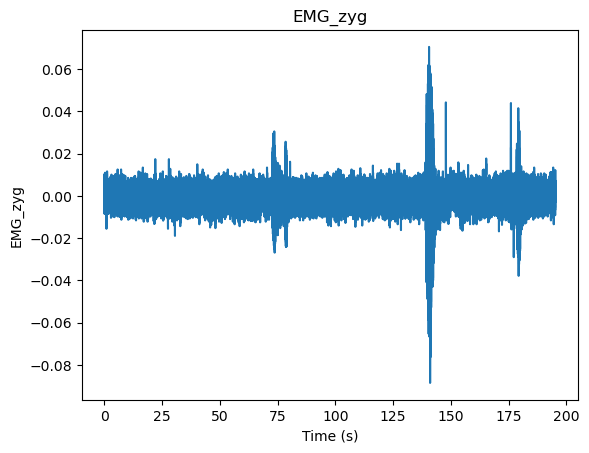

In [14]:
# Plot data
plt.plot(sub_dat['Time'], sub_dat['EMG_zyg'])
plt.xlabel('Time (s)')
plt.ylabel('EMG_zyg')
plt.title('EMG_zyg')
plt.show()

Text(0.5, 1.0, 'nk.emg_clean()')

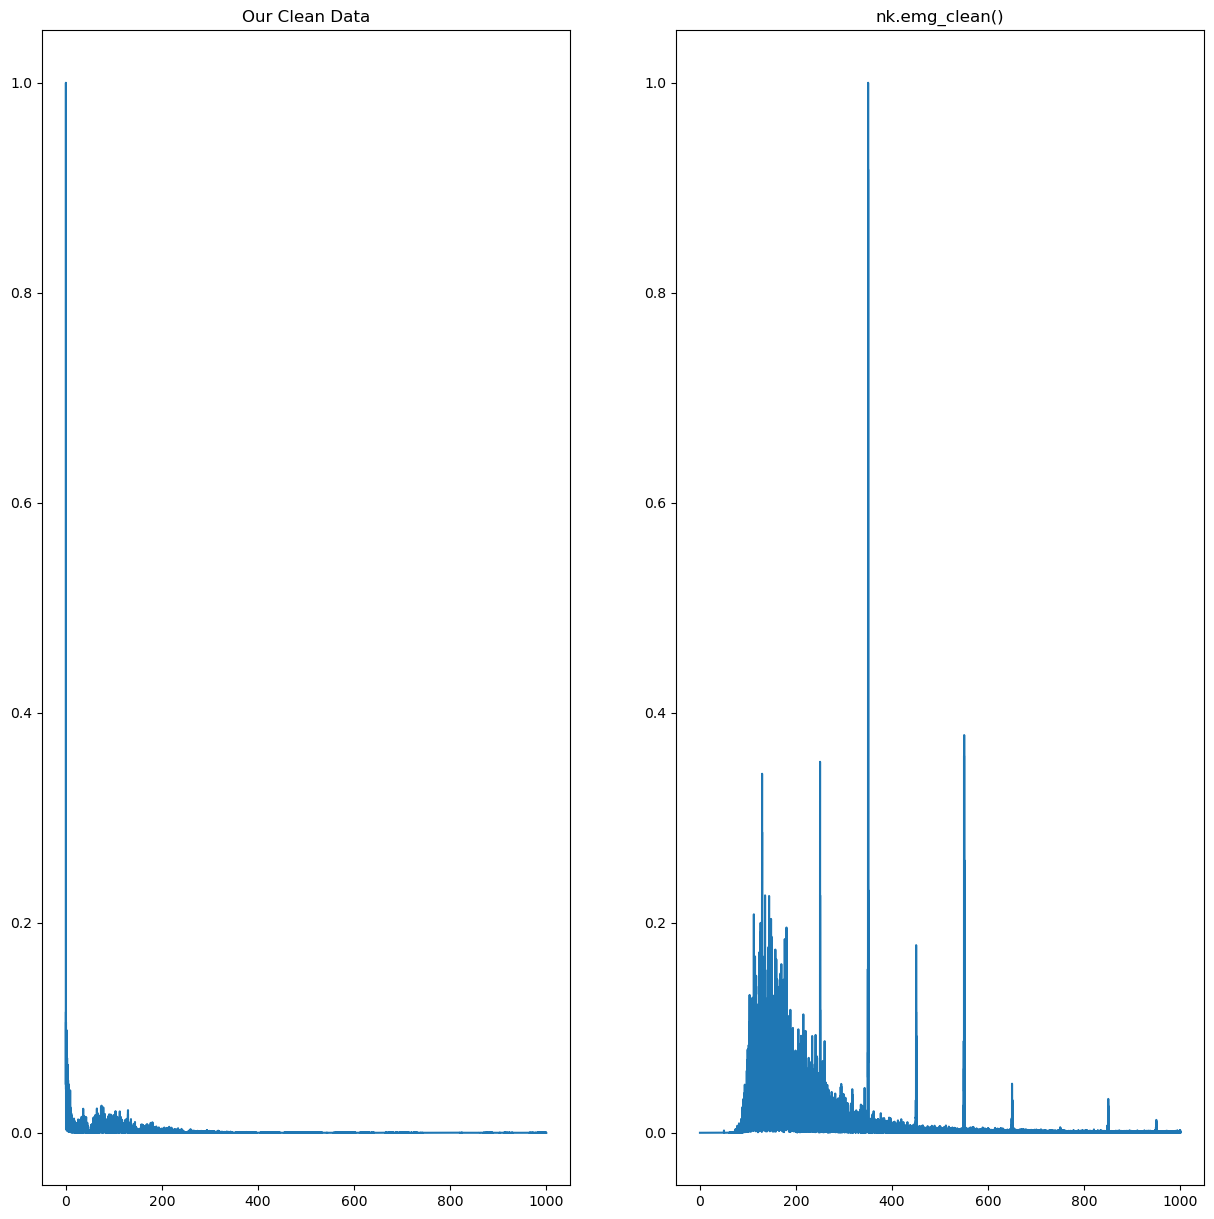

In [15]:
sr = 2000

# Test using the clean function
s10_3 = 'Data/Raw-Data/Raw_PID_01-10/10/10-03-01.csv'
sub_dat = pd.read_csv(s10_3)
emg_signal = nk.signal_sanitize(sub_dat['EMG_zyg'])
emg_cleaned = nk.emg_clean(emg_signal, sampling_rate=sr)
psd_zyg2 = nk.signal_psd(emg_cleaned, sampling_rate=sr)

# Compare with our cleaning function
s10_3_clean = 'Data/Clean-Data/Clean_PID_01-10/10/10-03-01.csv'
sub_dat = pd.read_csv(s10_3_clean)
psd_zyg1 = nk.signal_psd(sub_dat['EMG_zyg'], sampling_rate=sr)

# Make plots
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].plot(psd_zyg1['Frequency'], psd_zyg1['Power'])
axs[0].set_title('Our Clean Data')
axs[1].plot(psd_zyg2['Frequency'], psd_zyg2['Power'])
axs[1].set_title('nk.emg_clean()')

In [16]:
signals, info = nk.emg_process(sub_dat['EMG_zyg'], sampling_rate=sr)
signals

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity,EMG_Onsets,EMG_Offsets
0,0.003673,-0.000008,-2.552418e-07,0.0,0,0
1,0.002893,-0.001266,-2.152191e-07,0.0,0,0
2,0.003437,-0.001192,-1.757062e-07,0.0,0,0
3,0.004484,-0.000601,-1.367967e-07,0.0,0,0
4,0.005459,-0.000055,-9.857868e-08,0.0,0,0
...,...,...,...,...,...,...
390564,0.000786,0.000368,6.291338e-07,0.0,0,0
390565,-0.000469,-0.000860,6.273057e-07,0.0,0,0
390566,0.000878,0.000458,6.256643e-07,0.0,0,0
390567,0.001123,0.000624,6.242139e-07,0.0,0,0


In [19]:
sub_analysis = nk.emg_analyze(signals, sampling_rate=sr, method="auto")
sub_analysis

,EMG_Activation_N,EMG_Amplitude_Mean
0,168.0,0.000003


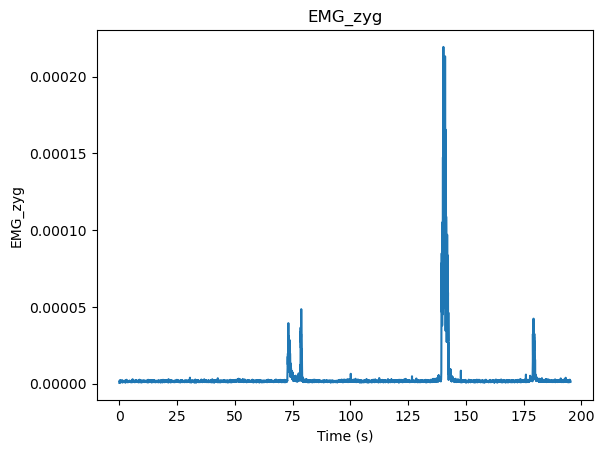

In [7]:
plt.plot(sub_dat['Time'], signals['EMG_Amplitude'])
plt.xlabel('Time (s)')
plt.ylabel('EMG_zyg')
plt.title('EMG_zyg')
plt.show()

In [8]:
s10_3_clean = 'Data/Clean-Data/Clean_PID_01-10/10/10-03-01.csv'

sub_dat = pd.read_csv(s10_3_clean)
print('rows =', len(sub_dat.index))
sub_dat.head()

rows = 390569


,Unnamed: 0,Time,EMG_zyg,EMG_cor,ECG,Respiration,Events
0,0,0.0005,0.003673,0.003673,0.235596,0.256653,0.0
1,1,0.0010,0.002893,0.003325,0.235291,0.256653,0.0
2,2,0.0015,0.003437,0.002010,0.234680,0.256348,0.0
3,3,0.0020,0.004484,0.004206,0.233765,0.256348,0.0
4,4,0.0025,0.005459,0.006690,0.232544,0.256348,0.0


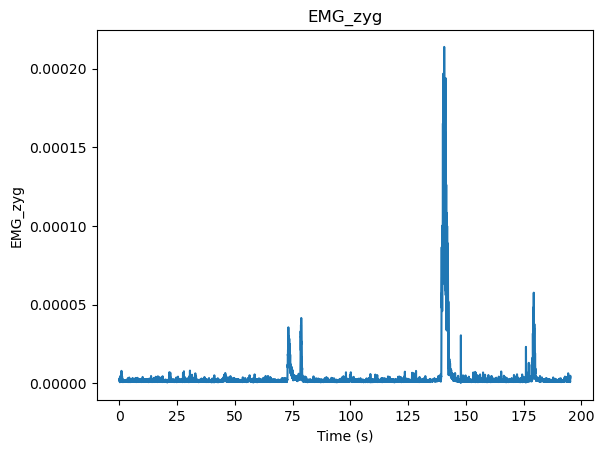

In [14]:
test = nk.signal_sanitize(sub_dat['EMG_zyg'])
test = nk.emg_amplitude(test)
plt.plot(sub_dat['Time'], test)
plt.xlabel('Time (s)')
plt.ylabel('EMG_zyg')
plt.title('EMG_zyg')
plt.show()